# Dynamics of a mixture of mesogens and SW nanoparticles

2022-06-21 v 0.1 Code for SW free energy and derivatives from 01_LSA_plots.ipynb

In [65]:
# Load packages
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import os

## Simulation parameters


In [66]:
sw_lambda=1.1     # SW range
T= 1.5            # reduced temperature "T star", T* = (k T)/epsilon
tau = -0.5        # tau = T/T_IN -1; negative values imply that the nematic phase is stable.


# Initial conditions
n_wavelengths = 2 # n_wavelengths es el número de longitudes de onda que caben en la caja, use only powers of two

c0= 0.050
s0= 0.001
Ampl = 0.001 # Ampl es la amplitud de la perturbación


# Time steps
nTimeSteps   =  1000  # total number of time steps to run
print_period =  100  # number of time steps between program printouts


# Parameters for the scaled dynamical equations
R = 10.0      # Reduced diffusivity, R
alphap=0.05  # Reduced coupling parameter, alpha'

# Finite differences grid parameters
L = 256    # Physical spatial size
N = L+2   # Augmented grid size with two extra points for PBC buffers
nb = 1    # numero de bloques (quizás nb por notebook), el número de veces que se repite una iteración
dx = 1.0      # pixel size
dt = 0.01     # time step

T_total = nTimeSteps*dt  # Total simulation time

# Euler-Maruyama parameters: mean and standard deviation of noise term
mu_mean, sigma_stdev = 0, 0.0001

# Fixed concentration scale phi = r_0/alpha,
# so that rho = (N/V) sigma^3 is given as rho = phi * c.

# Parameter phi =  8.0/7.0 approximately, according
# to the Paper 2 analysis of the decrease of the clearing point temperature
# with increasing nanoparticle volume fraction.

phi = 8.0/7.0

# Parameter mu_bar_0 = epsilon/(sigma**3 * alpha)
mu_bar_0 = 0.1  # Wild guess at the ratio of SW molecular density energy to NP+LC coupling parameter

## Square well free energy parameters

In [67]:
# Define parameters for the SW free energy, at selected values of lambda, 
# as given by Sastre et al. https://doi.org/10.1080/00268976.2017.1392051

b0 = {
    1.1:   -0.74484,
    1.2:   -1.51817,
    1.3:   -2.40494,
    1.4:   -3.46854,
    1.5:   -4.74229,
    1.6:   -6.24987,
    1.7:   -8.01193,
    1.8:   -10.0523
}

b1 = {
    1.1:   -0.382173,
    1.2:   -1.58568,
    1.3:   -3.04343,
    1.4:   -4.36238,
    1.5:   -5.34853,
    1.6:   -5.88535,
    1.7:   -5.8906,
    1.8:   -5.27555
}

b2 = {
    1.1:    -1.63313,
    1.2:    -1.40168,
    1.3:    -1.16285,
    1.4:     1.46006,
    1.5:     3.10155,
    1.6:     4.48369,
    1.7:     5.34814,
    1.8:     5.38749
}

In [68]:
# For lambda = 1.1, A2 = a0 rho* + a1 rho*^2 + a2 rho*^3
a0=-0.315714
a1=-0.405783
a2=0.4394

# Matrix A collects constants for cases lambda> 1.1, 
# when A2 = g2 rho* exp(-h2 rho*^2) + f2 tanh( c2 rho*)  
#  g2,        h2,     f2,        c2
#A=np.array( [[0,0,0,0],
#   [-0.754123,1.54113, 0       , 0     ],    # lambda = 1.20
#   [-0.400299,4.81518,-0.221092,3.42486],    # lambda = 1.30
#   [-0.311957,9.62637,-0.275382,4.80383],    # lambda = 1.40
#   [-0.301985,12.7563,-0.305239,6.10676],    # lambda = 1.50
#   [-0.242938,10.8684,-0.333435,7.67705],    # lambda = 1.60
#   [-0.310091,16.5368,-0.376464,8.31355],    # lambda = 1.70
#   [ 0.385677,1.98941,-0.539128,8.40071]])   # lambda = 1.80, WARNING g2 was (-) in Ref.


g2 = {
    1.2:    -0.754123,
    1.3:    -0.400299,
    1.4:    -0.311957,
    1.5:    -0.301985,
    1.6:    -0.242938,
    1.7:    -0.310091,
    1.8:     0.385677    # WARNING g2 was incorrectly given as negative for lambda = 1.80 in
                         # Sastre et al. https://doi.org/10.1080/00268976.2017.1392051
}

h2 = {
    1.2:    1.54113,
    1.3:    4.81518,
    1.4:    9.62637,
    1.5:    12.7563,
    1.6:    10.8684,
    1.7:    16.5368,
    1.8:    1.98941,
}

f2 = {
    1.2:     0.000000,
    1.3:    -0.221092,
    1.4:    -0.275382,
    1.5:    -0.305239,
    1.6:    -0.333435,
    1.7:    -0.376464,
    1.8:    -0.539128,
}

c2 = {
    1.2:   0.00000,
    1.3:   3.42486,
    1.4:   4.80383,
    1.5:   6.10676,
    1.6:   7.67705,
    1.7:   8.31355,
    1.8:   8.40071
}

### Hard sphere aHS

In [69]:
# We use _c_ as our scaled concentration variable, with  rho* = phi c.
# noinspection PyPep8Naming
def aHS(eta):
#    rho = phi*c
#    eta = math.pi/6.0 * rho
    result= (4.0*eta - 3.0*eta**2)/(1.0-eta)**2
    return result

# First derivative of aHS with respect to eta
def daHS(eta):
#    rho = phi*c
#    eta = math.pi/6.0 * rho
    result =2.0*(2.0-eta)/(1.0-eta)**3
    return result


# First derivative of aHS with respect to eta
def d2aHS(eta):
#    rho = phi*c
#    eta = math.pi/6.0 * rho
    result =(10.0-4.0*eta)/(1-eta)**4
    return result


### First order in $\beta  = \frac{1}{k T}$

In [70]:
# Free energy perturbation A1
def A1(rho, Lambda):
    # with b0, b1 and b2 as dictionaries that depend on Lambda,
    # the first order perturbation term is
    # A1 = b0*rho* + b1*rho*^2 + b2*rho*^3.

#    rho = phi*c
    result= b0[Lambda] * rho + b1[Lambda] * rho**2 + b2[Lambda] * rho**3
    return result

# First Derivative of A1 with respect to rho*
def dA1(rho, Lambda):
#    rho = phi*c
    result = b0[Lambda] + 2.0 * b1[Lambda]  * rho + 3.0 * b2[Lambda] * rho**2
    return result

# Second Derivative of A1 with respect to rho*
def d2A1(rho, Lambda):
#    rho = phi*c
    result =  2.0 * b1[Lambda]  + 6.0 * b2[Lambda] * rho
    return result


### Second order in $\beta$ 

In [71]:
# Free energy perturbation A2 
def A2(rho, Lambda):
#    rho = phi*c
    
    if abs(Lambda-1.10) <= 0.05:
        result= a0 * rho + a1 * rho**2 + a2 * rho**3
    else:
        #      A[0]         A[1]         A[2]     A[3]
        # A2 = g2 rho* exp(-h2 rho*^2) + f2 tanh( c2 rho*)
        result=g2[Lambda] * rho * math.exp( -h2[Lambda] * rho**2) + f2[Lambda] * math.tanh(c2[Lambda] * rho)
    return result

# First derivative of A2 with respect to rho*
def dA2(rho, Lambda):
#    rho = phi*c

    if abs(Lambda-1.10) <= 0.05:
        result = a0 + 2.0* a1  * rho + 3.0 * a2 * rho**2
    else:
        result =(
                  g2[Lambda] * math.exp( -(h2[Lambda])*rho**2 )
                ) * (1.0- 2.0 * h2[Lambda] * rho**2) + \
                f2[Lambda] * c2[Lambda] /math.cosh(c2[Lambda]*rho)**2
    return result

# Second derivative of A2 with respect to rho*
def d2A2(rho, Lambda):
#    rho = phi*c

    if abs(Lambda-1.10) <= 0.05:
        result = 2.0 * a1  + 6.0 * a2 * rho
    else:
        result =(
                  2.0 * g2[Lambda] *h2[Lambda]* rho * math.exp( -(h2[Lambda])*rho**2 )
                ) * (-3.0 + 2.0 * h2[Lambda] * rho**2) - \
                2.0 * c2[Lambda]**2 * f2[Lambda] * math.cosh( c2[Lambda] *rho ) / math.cosh( c2[Lambda]*rho )**2
    return result




### Total free energy a_SW = A_SW/(N k T) 

In [72]:
def aSW(c,Lambda,T):
    rho = phi*c
    eta = math.pi/6.0 * rho

    result = aHS(eta) + A1(rho,Lambda)/T + A2(rho,Lambda)/T**2
    return result

## SW chemical potential

In [73]:
# Reduced chemical potential mu_bar:
def mu_bar(c, Lambda, T):

    rho = phi*c
    eta = math.pi/6.0 * rho

    result=                 ( aHS(eta)  + eta * daHS(eta)            ) + \
                  (1.0/T) * ( A1(rho,Lambda) + rho * dA1(rho,Lambda) ) + \
               (1.0/T**2) * ( A2(rho,Lambda) + rho * dA2(rho,Lambda) )

    result = mu_bar_0 * T * result
    return result


# Derivative of reduced chemical potential mu_bar, partial mu_bar/partial c:
def dmu_bar(c, Lambda, T):

    rho = phi*c
    eta = math.pi/6.0 * rho

    result= T * math.pi/6.0 * ( 2.0 * daHS(eta)       + eta * d2aHS(eta) ) + \
                                 ( 2.0 * dA1(rho,Lambda) + rho * d2A1(rho,Lambda) ) + \
                                 ( 2.0 * dA2(rho,Lambda) + rho * d2A2(rho,Lambda) ) / T
    result = mu_bar_0 * result
    return result





## Finite difference operations

In [74]:
# Laplacian operator in 2D using finite differences.
def laplacian2D(Z):

    # center slice with no periodic boundary condition buffer rows and columns
    center  = Z[1:-1, 1:-1]

    #west, east, north and south slices, with same size as center
    w   = Z[0:-2, 1:-1]
    e   = Z[2:  , 1:-1]
    n   = Z[1:-1, 2:  ]
    s   = Z[1:-1, 0:-2]


    #north-west, north east, south-east, and south-west slices, with same size as center
    nw  = Z[0:-2, 2:  ]
    ne  = Z[2:  , 2:  ]
    se  = Z[2:, 0:-2]
    sw  = Z[0:-2, 0:-2]

    # Weights for the different contributions to the laplacian
    dif2 = (w+e+n+s)/6.0 + (ne+nw+se+sw)/12.0
    dif2 = dif2 - center

    # Scale by grid size squared and return.
    dif2 = dif2/dx**2

    return dif2

In [75]:
# Apply periodic boundary conditions
def PBC(Z):
    # Fill two buffer columns
    Z[ 0,:] = Z[-2,:]    # Fill column  0 from column -2
    Z[-1,:] = Z[ 1,:]    # Fill column -1 from column  1

    # Fill two buffer rows
    Z[:, 0] = Z[:,-2]   # fill row  0 from row -2
    Z[:,-1] = Z[:, 1]   # fill row -1 from row  1

    # Fill four buffer corners
    Z[0,0]   = Z[-2,-2]
    Z[0,-1]  = Z[-2, 1]
    Z[-1,0]  = Z[ 1,-2]
    Z[-1,-1] = Z[ 1, 1]


    return Z

In [76]:
# Apply plane-wave perturbations to a given field
# field is an array, k is the wavenumber, and A is the perturbation amplitude
def perturba(field, k, A):
    for x in range(len(field)):
        for y in range(len(field)):
            field[x, y] += A*np.sin(k*float(y))
            field[x, y] += A*np.sin(k*float(x))
    return field


In [77]:
# Auxiliar field inside the laplacian operator (in the dynamical equation for c)

# inlaplacian = c mu* + alpha' s^2, which is what is inside the Laplacian operator in the
# dynamical equation for the conserved variable c
def generalized_mu(c, s):
# DEBUG
#     print("inlaplacian::")
#     print("inlaplacian::input: <c>=",             c.mean(), "+/-",           c.std())

    mu_estrella= np.full((N,N), 0.000)  # CAREFUL mu_estrella = c is an alias, not a copy, of the object "c"

    for i in np.arange(N):
        for j in np.arange(N):
            mu_estrella[i][j] = mu_bar(c[i][j],sw_lambda,T)

    resultado= mu_bar_0 * mu_estrella + alphap * (s**2)/2.0

# DEBUG
#     print("inlaplacian::out: <c>=", c.mean(), "+/-", c.std())
#     print("inlaplacian::out: <mu*>=", mu_estrella.mean(), "+/-", mu_estrella.std())
#     print("inlaplacian::out: <res>=",   resultado.mean(), "+/-",   resultado.std())

    return resultado

In [78]:
# Advance the fields using the dynamics for one time step
def solve_dynamics(c,s):


    thermal_s = np.random.normal(mu_mean, sigma_stdev, (L,L))
    thermal_c = np.random.normal(mu_mean, sigma_stdev, (L,L))


    # DEBUG:
    #print("solve_dynamics::time_step=",time_step)
    # print("solve_dynamics::input: <c>=", c.mean(), "+/-", c.std())
    #
    # For dilute HS:
    # auxHS = c + alphap * s**2

    # For SW:
    auxSW = generalized_mu(c,s)

    #nabla2_aux almacena laplaciano de aux
    nabla2_aux = laplacian2D(auxSW)
    nabla2_s   = laplacian2D(s)

    #parámetro de orden y concentracion en el centro
    sc = s[1:-1,1:-1]
    cc = c[1:-1,1:-1]

    #Ecuaciones no lineales, se hace un incremento en el tiempo
    s[1:-1,1:-1] = sc + dt * (nabla2_s - tau * sc - sc**3 - sc * cc)  + thermal_s
    c[1:-1,1:-1] = cc + dt * R * nabla2_aux + thermal_c

    #s[1:-1,1:-1] = sc + dt * (nabla2_s - r * sc - sc**3 - sc * cc)
    #c[1:-1,1:-1] = cc + dt * R * nabla2_aux

    #se aplican condiciones periodicas en la frontera tanto en s como en c
    for x in (s, c):
        PBC(x)

    # DEBUG
#     print("solve_dynamics::<auxSW>=", auxSW.mean(), "+/-", auxSW.std())
#     print("solve_dynamics::<auxHS>=", auxHS.mean(), "+/-", auxHS.std())
#     print("solve_dynamics::<nabla2_aux>=", nabla2_aux.mean(), "+/-", nabla2_aux.std())
#     print("solve_dynamics::out: <c>=", c.mean(), "+/-", c.std())

## Output functions

In [79]:
# Save s and c fields to files
def save_fields(s, c, step, nb):
    LC_file = "matrix" + "_s_" + str(step) + "_nb_" + str(nb) + ".txt"
    np.savetxt(LC_file, s, delimiter="\t")

    NPs_file = "matrix" + "_c_" + str(step) + "_nb_" + str(nb) + ".vtk"
    np.savetxt(NPs_file, c, delimiter="\t")

In [80]:
# Plot the 2D arrays, using grayscale for c and "seismic" colormap for s
def plot_fields_in_2D(s,c,i):

    plt.figure(figsize=(10, 3.5))

    plt.subplot(1, 2, 1)
    plt.imshow(c[1:-1,1:-1], cmap=plt.cm.gray)
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.imshow(s[1:-1,1:-1], cmap=plt.cm.seismic)
    plt.colorbar()

    plt.savefig('fields_step_{}.png'.format(i))
    plt.show()

In [81]:
# Plot 1D profiles of c and s, using black for c and red for s
def plot_fields_in_1D(s,c,i):
    plt.figure(figsize=(10, 3.5))

    plt.subplot(1, 2, 1)
    plt.plot(c[1:-1,1:-1], "k")  # k means blacK


    plt.subplot(1, 2, 2)
    plt.plot(s[1:-1,1:-1], "r")  # r means Red

    plt.savefig('profile_fields_step_{}.png'.format(i))
    plt.show()

# Main simulation: quench from isotropic to nematic phase

## Initialize the program

the wavenumber k= 0.04908738521234052
c.mean = 0.0500 s.mean = 0.0010
c.min  = 0.0480  s.min = -0.0010
c.max  = 0.0520  s.max = 0.0030


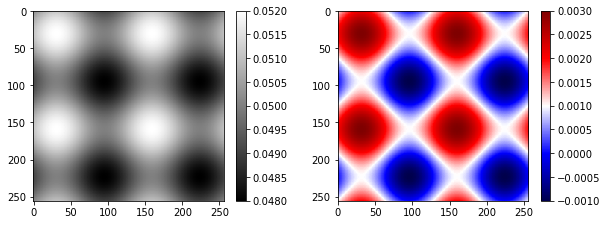

In [82]:
# Initial conditions for c and s start as homogenoeus fields
for block in range(1, nb+1):
    c = np.full((N,N), c0)
    s = np.full((N,N), s0)

# Calculate the wavelength and the wavenumber from size L
# and number of wavelengths in it
wavelength = L // n_wavelengths       #  CAREFUL: // is the integer division operator
k = 2.0 * np.pi / wavelength          #  k=2 pi/wavelength is the wavenumber
print('the wavenumber k=',k)

# Apply plane-wave perturbations to s and c
for field in (s,c):
    perturba(field, k, Ampl)

# Print out statistics and plots of c and s to diagnose initial conditions
print("c.mean = {:.4f} s.mean = {:.4f}" .format(c.mean(), s.mean()))
print("c.min  = {:.4f}  s.min = {:.4f}" .format(c.min(), s.min()))
print("c.max  = {:.4f}  s.max = {:.4f}" .format(c.max(), s.max()))

# Plot s and c in 2D and 1D to diagnose initial conditions
plt.figure(figsize=(10, 3.5))
plt.subplot(1, 2, 1)
plt.imshow(c[1:-1,1:-1], cmap=plt.cm.gray)
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(s[1:-1,1:-1], cmap=plt.cm.seismic)
plt.colorbar()
plt.savefig('fields_step_0.png')
plt.show()

#plot_fields_in_1D(s, c, i)



# Export figures of initial conditions

#dir = os.chdir('/home/erick/Desktop/pruebas/campo_C')
#plt.imshow(c, cmap=plt.cm.gray)
#plt.colorbar()
#plt.savefig('imagen0.png')
#plt.show()

#dir = os.chdir('/home/erick/Desktop/pruebas/Campo_S')
#plt.imshow(s, cmap=plt.cm.seismic)
#plt.colorbar()
#plt.savefig('imagen0.png')


In [83]:
# Save initial conditions to files
NPs_file = "matrix" + "_c_" + str(0)+ "_nb_" + str(nb) + ".vtk"
np.savetxt(NPs_file, c, delimiter="\t")
print(type(c))

<class 'numpy.ndarray'>


## Solve the dynamics

In [ ]:
print("Program will run nTimeSteps: ", nTimeSteps)
print("Print results each print_period steps: ", print_period)
print("Total simulation time at the end:", T_total)

print("Temperature: = {:.3f}" .format(T))
print("SW range lambda  = {:.3f}" .format(1+sw_lambda/10.0))
print("wavenumber k = {:.3f}" .format(k))
print("wavelength = {:.3f}" .format(wavelength))

# Apply periodic boundary conditions to fields s & c
for x in (s,c):
    PBC(x)

# declare empty arrays vacíos
time_step = []
amplitude_c_step = []
amplitude_s_step=[]

#define el tiempo inicial de corrida, será igual al tiempo real de comienzo
t0 = time.time()

# Save initial state
#save_fields(s, c, 0, block)


# Solve the dynamics
for i in range(1,nTimeSteps+1):

    solve_dynamics(c,s)
    #save_fields(s, c, i, block)

    if( (i % print_period) == 0 ):
        print(" ")
        print("time_step=", i)

        tf = time.time()
        print("Tiempo CPU en segundos: {:.2f}" .format(tf-t0))


        print("c.mean = {:.4f} s.mean = {:.4f}" .format(c.mean(), s.mean()))
        print("c.min  = {:.4f}  s.min = {:.4f}" .format(c.min(), s.min()))
        print("c.max  = {:.4f}  s.max = {:.4f}" .format(c.max(), s.max()))

        plot_fields_in_2D(s,c,i)
        plot_fields_in_1D(s,c,i)


#    Save to disk the pictures for the NP concentration and LC order parameter

#    plt.imshow(c, cmap=plt.cm.gray)
#    plt.colorbar()
#    plt.savefig('imagen{}.png'.format(i))
#    plt.show()


#    plt.imshow(s, cmap=plt.cm.seismic)
#    plt.colorbar()
#    plt.savefig('imagen{}.png'.format(i))
#    plt.show()


        # Measure the amplitude of the perturbations in c and s over time
        # Sample the central region
        region_min = N//4         # Careful, // means integer division
        region_max = N//4 + N//2  # Again, // means integer division

        region_c = c[region_min:region_max]
        region_s=  s[region_min:region_max]

        # Obtain min and max for c and s in that region
        max_region_c= region_c.max()
        max_region_s= region_s.max()
        min_region_c= region_c.min()
        min_region_s= region_s.min()

        # Amplitude for each field equals half the range between the maximum and minimum values
        amplitude_c= (max_region_c-min_region_c)/2
        amplitude_s= (max_region_s-min_region_s)/2

        # Print out statistics
        print("max_region_c:",max_region_c, ", max_region_s:",max_region_s )
        print("min_region_c:",min_region_c, ", min_region_s:",min_region_s,)
        print("amplitude_c:",amplitude_c,   ", amplitude_s:",amplitude_s)

        # Collect amplitudes and corresponding time steps into arrays
        time_step.append(float(i))
        amplitude_c_step.append(amplitude_c)
        amplitude_s_step.append(amplitude_s)


print("Program end.")
# End of main simulation program

Program will run nTimeSteps:  1000
Print results each print_period steps:  100
Total simulation time at the end: 10.0
Temperature: = 1.500
SW range lambda  = 1.110
wavenumber k = 0.049
wavelength = 128.000


# Analysis of amplitude vs time

In [ ]:
# Plot amplitude of NP concentration c vs time_step
plt.plot(time_step, amplitude_c_step, "k-")
plt.xlabel("t")
plt.ylabel("NP concentration amplitude ")
plt.savefig('amplitude_time_c.png')
plt.show()

In [ ]:
# Plot amplitude of LC order parameter s vs time_step
plt.plot(time_step, amplitude_s_step, "r-")
plt.xlabel("t")
plt.ylabel("LC Order parameter amplitude")
plt.savefig('amplitude_time_s.png')
plt.show()

In [ ]:
plt.semilogy(time_step, amplitude_c_step, "k-")
plt.savefig('amplitude_time_semilog_c.png')

In [ ]:
plt.semilogy(time_step, amplitude_s_step, "r-")
plt.savefig('amplitude_time_semilog_s.png')

